In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

In [2]:
# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class PenultimateOutputsDataset(Dataset):
    def __init__(self, folder_path, device='cpu'):
        with open(f'{folder_path}/penultimate_layer_outputs/data.json') as data:
            self.data_tensors = json.load(data)
        self.file_list = [f'{folder_path}/penultimate_layer_outputs/penultimate_layer_outputs_{index}.pt' for index in range(self.data_tensors['last_file_indice']+1)]
        self.labels = torch.load(f'{folder_path}/penultimate_layer_labels.pt', map_location=device)
        self.length = self.data_tensors['min_size_segmentation']*self.data_tensors['last_file_indice']+torch.load(f'{folder_path}/penultimate_layer_outputs/penultimate_layer_outputs_{self.data_tensors["last_file_indice"]}.pt', map_location=device).shape[0]
        self.device = device
        self.data_cache = None
        
    def __len__(self):
        return self.length

    def __getitem__(self, index):
        if index < 0 or index >= self.length :
           raise ValueError(f'Index need to be between 0 and {self.length-1}')
        index_file = index//self.data_tensors['min_size_segmentation']
        index_in_file = index%self.data_tensors['min_size_segmentation']
        if (self.data_cache is None) or self.data_cache[0] != index_file :
            file = self.file_list[index_file]
            tensors = torch.load(file, map_location=self.device)
            self.data_cache = (index_file, tensors)
        tensor = self.data_cache[1][index_in_file]
        label = self.labels[index]
        return tensor, label


In [4]:
outputs_folder = "../data/saved_outputs/train"
batch_size = 256
nb_epoque = 90
nb_classe = 1000
input_size = 2048


weight_decay_parameter = 1e-4
learning_rate = 0.1
momentum = 0.9
lr_decay_step = 30
decay_rate = 0.1

In [5]:
moyenne_erreur_classe_model = []
loss_epoch = []
dataset = PenultimateOutputsDataset(outputs_folder)
train_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=True)
nb_image_classe = torch.bincount(dataset.labels).to(DEVICE) # compte le nombre de tous les entiers compris entre 0 et l'entier maximum dans le tenseur d'origine

In [6]:
class LogisticRegression(nn.Module): 
    def __init__(self, input_size, num_classes): 
        super(LogisticRegression, self).__init__() 
        self.linear = nn.Linear(input_size, num_classes) 
    def forward(self, x): 
        out = self.linear(x) 
        return out
    def load_weights(self, weights) :
        self.load_state_dict(weights)

In [7]:
model = LogisticRegression(input_size=input_size, num_classes=nb_classe)
model = model.to(DEVICE)
for epoch in range(nb_epoque):

    model.load_weights(torch.load(f'../data/saved_models/same_parameter_real_optimized_function/epoch-{epoch}.pt', map_location=DEVICE))    
    
    erreur_total_classe = torch.zeros(nb_classe, device=DEVICE)
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{nb_epoque}]"): 
            
            # Move inputs and labels to the device 
            inputs = inputs.to(DEVICE) 
            labels = labels.to(DEVICE) 
      
            # Forward pass 
            outputs = model(inputs) 
            erreur = torch.nn.functional.cross_entropy(outputs,labels,reduction='none') + weight_decay_parameter * sum(t.pow(2).sum() for t in model.state_dict().values()) / 2
            vrai_loss = torch.mean(erreur).item() #recupère la loss du batch  
            
            erreur_total_classe.index_add_(0,labels,erreur)
        print(f"Global minimized function value : {vrai_loss}") 
        loss_epoch.append(vrai_loss)
        moyenne_erreur_classe_model.append((erreur_total_classe/nb_image_classe).tolist())
            

Epoch [1/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:28<00:00, 178.42it/s]


58.38216251277156
Global minimized function value : 31.609811782836914


Epoch [2/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:28<00:00, 173.99it/s]


65.94128634284212
Global minimized function value : 16.715219497680664


Epoch [3/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 155.75it/s]


64.2417420991955
Global minimized function value : 12.138627052307129


Epoch [4/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 156.09it/s]


61.33915406812695
Global minimized function value : 11.23188591003418


Epoch [5/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 162.38it/s]


60.51755938140773
Global minimized function value : 11.467166900634766


Epoch [6/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 154.12it/s]


60.85412752591973
Global minimized function value : 11.552794456481934


Epoch [7/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 125.11it/s]


61.4664598760349
Global minimized function value : 11.499114990234375


Epoch [8/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 128.02it/s]


60.84117058900206
Global minimized function value : 11.362174987792969


Epoch [9/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.49it/s]


60.58187574297496
Global minimized function value : 11.512304306030273


Epoch [10/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 124.74it/s]


60.572665390226256
Global minimized function value : 11.493085861206055


Epoch [11/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 127.04it/s]


60.76420950586458
Global minimized function value : 11.624197959899902


Epoch [12/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.25it/s]


60.87567038489127
Global minimized function value : 11.526086807250977


Epoch [13/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.89it/s]


61.01686977575913
Global minimized function value : 11.451667785644531


Epoch [14/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 153.93it/s]


60.65228030381675
Global minimized function value : 11.455194473266602


Epoch [15/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 152.49it/s]


60.81018321577125
Global minimized function value : 11.417119979858398


Epoch [16/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 154.43it/s]


60.7829424267094
Global minimized function value : 11.500715255737305


Epoch [17/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 152.62it/s]


60.726665610338074
Global minimized function value : 11.478266716003418


Epoch [18/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 161.46it/s]


60.8387509200596
Global minimized function value : 11.527132034301758


Epoch [19/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 162.36it/s]


61.01905528319103
Global minimized function value : 11.480039596557617


Epoch [20/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 153.90it/s]


60.740715300971694
Global minimized function value : 11.432167053222656


Epoch [21/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 152.51it/s]


60.54440990128531
Global minimized function value : 11.503726959228516


Epoch [22/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 161.83it/s]


60.85303477220378
Global minimized function value : 11.486150741577148


Epoch [23/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 165.03it/s]


60.948650722349235
Global minimized function value : 11.441056251525879


Epoch [24/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 152.55it/s]


60.89128115226196
Global minimized function value : 11.427059173583984


Epoch [25/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 155.20it/s]


60.68490680762149
Global minimized function value : 11.473190307617188


Epoch [26/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 161.57it/s]


60.59553516442431
Global minimized function value : 11.517332077026367


Epoch [27/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 161.98it/s]


60.71495753481006
Global minimized function value : 11.617388725280762


Epoch [28/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 147.28it/s]


60.9513826066391
Global minimized function value : 11.503610610961914


Epoch [29/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 160.68it/s]


60.96106128240893
Global minimized function value : 11.402645111083984


Epoch [30/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 162.26it/s]


60.52505254974566
Global minimized function value : 11.479290962219238


Epoch [31/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 157.71it/s]


81.33592263928122
Global minimized function value : 8.64576530456543


Epoch [32/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 143.45it/s]


84.40343842762107
Global minimized function value : 8.054566383361816


Epoch [33/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 163.10it/s]


85.83283834191795
Global minimized function value : 7.273784160614014


Epoch [34/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 160.55it/s]


86.55343136374883
Global minimized function value : 6.525631427764893


Epoch [35/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 155.79it/s]


87.0722552173136
Global minimized function value : 5.864129543304443


Epoch [36/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 152.67it/s]


87.3499707688381
Global minimized function value : 5.28082799911499


Epoch [37/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 161.57it/s]


87.67038176912143
Global minimized function value : 4.763162136077881


Epoch [38/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 158.58it/s]


87.82563085062291
Global minimized function value : 4.303595542907715


Epoch [39/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 152.42it/s]


88.03856171755906
Global minimized function value : 3.8960187435150146


Epoch [40/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 156.08it/s]


88.11060540897479
Global minimized function value : 3.5340211391448975


Epoch [41/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 161.05it/s]


88.25570749168531
Global minimized function value : 3.212026596069336


Epoch [42/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 163.07it/s]


88.2815433116838
Global minimized function value : 2.9231467247009277


Epoch [43/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 148.42it/s]


88.36677810152774
Global minimized function value : 2.6643595695495605


Epoch [44/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 159.09it/s]


88.32166298382647
Global minimized function value : 2.432464122772217


Epoch [45/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 160.63it/s]


88.3553041875103
Global minimized function value : 2.225693464279175


Epoch [46/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 158.94it/s]


88.24485800836268
Global minimized function value : 2.0428965091705322


Epoch [47/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 147.47it/s]


88.2178513808114
Global minimized function value : 1.8821325302124023


Epoch [48/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 162.47it/s]


88.04589877822329
Global minimized function value : 1.7430006265640259


Epoch [49/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 160.95it/s]


87.94442879031384
Global minimized function value : 1.6239241361618042


Epoch [50/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 156.78it/s]


87.70230578839448
Global minimized function value : 1.5244678258895874


Epoch [51/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 152.24it/s]


87.53292896242255
Global minimized function value : 1.4422905445098877


Epoch [52/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 163.25it/s]


87.22914342938898
Global minimized function value : 1.375728964805603


Epoch [53/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 159.94it/s]


87.0224568694011
Global minimized function value : 1.3215575218200684


Epoch [54/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 154.62it/s]


86.70196781528091
Global minimized function value : 1.2777163982391357


Epoch [55/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 158.14it/s]


86.4742067193426
Global minimized function value : 1.2410768270492554


Epoch [56/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 162.66it/s]


86.16089861821293
Global minimized function value : 1.2102278470993042


Epoch [57/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 165.13it/s]


85.94851412813475
Global minimized function value : 1.183193325996399


Epoch [58/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 152.02it/s]


85.65557807842382
Global minimized function value : 1.1596299409866333


Epoch [59/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 153.97it/s]


85.48222050677234
Global minimized function value : 1.138313889503479


Epoch [60/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 164.93it/s]


85.22893580618296
Global minimized function value : 1.1199190616607666


Epoch [61/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 161.14it/s]


88.40190232811179
Global minimized function value : 0.9165429472923279


Epoch [62/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 149.45it/s]


89.71289457190203
Global minimized function value : 0.889988899230957


Epoch [63/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 157.90it/s]


90.30641594733551
Global minimized function value : 0.8739205002784729


Epoch [64/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 162.63it/s]


90.61956794079148
Global minimized function value : 0.8613170981407166


Epoch [65/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 160.97it/s]


90.80182364984424
Global minimized function value : 0.8505746126174927


Epoch [66/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 151.74it/s]


90.9225729354565
Global minimized function value : 0.8410523533821106


Epoch [67/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 160.96it/s]


91.00039261079937
Global minimized function value : 0.8324145674705505


Epoch [68/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:29<00:00, 167.81it/s]


91.0579963423972
Global minimized function value : 0.8245157599449158


Epoch [69/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 159.98it/s]


91.11177543598922
Global minimized function value : 0.8172637224197388


Epoch [70/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 154.11it/s]


91.15212926964244
Global minimized function value : 0.8105918765068054


Epoch [71/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 166.58it/s]


91.18678517320537
Global minimized function value : 0.80442875623703


Epoch [72/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 163.79it/s]


91.2194116770101
Global minimized function value : 0.7987168431282043


Epoch [73/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 155.88it/s]


91.2479013274616
Global minimized function value : 0.7934212684631348


Epoch [74/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 154.60it/s]


91.27061499398596
Global minimized function value : 0.7884966135025024


Epoch [75/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 163.90it/s]


91.29356282202086
Global minimized function value : 0.7839053273200989


Epoch [76/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 160.25it/s]


91.31276406588681
Global minimized function value : 0.7796016335487366


Epoch [77/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 150.67it/s]


91.32915537162603
Global minimized function value : 0.7755496501922607


Epoch [78/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 158.97it/s]


91.34468808515986
Global minimized function value : 0.771731436252594


Epoch [79/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 166.11it/s]


91.3613916062465
Global minimized function value : 0.7681128978729248


Epoch [80/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 164.99it/s]


91.37950009639648
Global minimized function value : 0.764673113822937


Epoch [81/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 150.82it/s]


91.39354978703011
Global minimized function value : 0.761398434638977


Epoch [82/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 160.01it/s]


91.40666283162149
Global minimized function value : 0.7582705020904541


Epoch [83/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 159.68it/s]


91.42118084527623
Global minimized function value : 0.7552717328071594


Epoch [84/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 159.79it/s]


91.43398167452018
Global minimized function value : 0.752389132976532


Epoch [85/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 151.07it/s]


91.44795331131695
Global minimized function value : 0.7496011853218079


Epoch [86/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 162.13it/s]


91.46067608672406
Global minimized function value : 0.7469027638435364


Epoch [87/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 161.95it/s]


91.47066697784129
Global minimized function value : 0.7442920207977295


Epoch [88/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:31<00:00, 157.17it/s]


91.47987733059
Global minimized function value : 0.7417625784873962


Epoch [89/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 155.12it/s]


91.49033654472836
Global minimized function value : 0.7393141388893127


Epoch [90/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:30<00:00, 164.97it/s]

91.50181045874581
Global minimized function value : 0.7369400858879089


In [57]:
moyenne_erreur_classe_model = torch.tensor(moyenne_erreur_classe_model)
t_k = [torch.argmin(moyenne_erreur_classe_model[:,l]).item() for l in range(nb_classe)]
r_k = [torch.min(moyenne_erreur_classe_model[:,m]).item() for m in range(nb_classe)]
t = torch.argmin(torch.tensor(loss_epoch))
r_t = torch.min(torch.tensor(loss_epoch))
decalage = torch.abs(torch.tensor(t_k) - t)
regret = torch.abs(torch.tensor(r_k) - r_k[t])

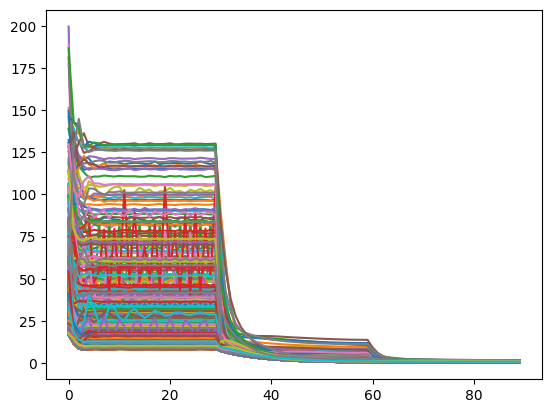

In [68]:
plt.plot(loss_epoch,color='black')
for n in range(0,1000):
    plt.plot(moyenne_erreur_classe_model[:,n])

In [89]:
torch.bincount(torch.tensor(t_k))

tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   2, 100,  15,   2,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0, 880])

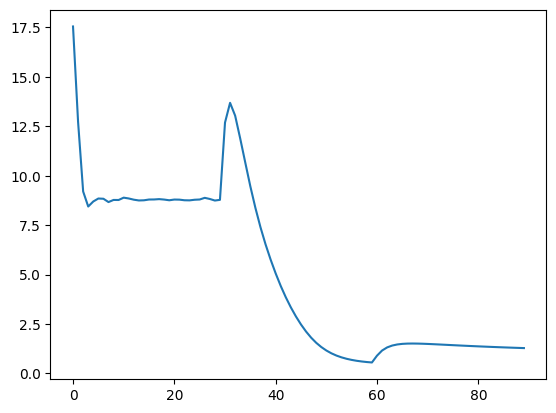

In [112]:
for tens in (torch.tensor(t_k)==59).nonzero()[93:94,0]:
    plt.plot(moyenne_erreur_classe_model[:,tens])

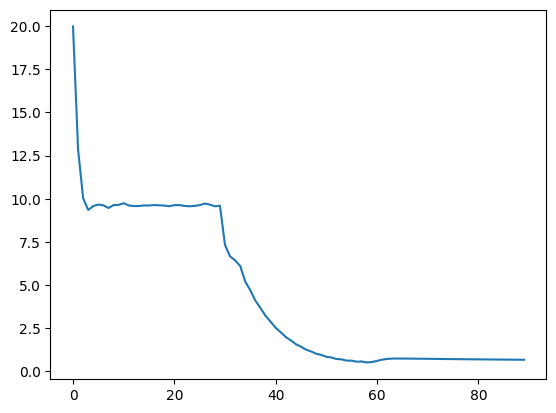

In [90]:
plt.plot(moyenne_erreur_classe_model[:,349])